# Fall Detection Model Training

I'm training an LSTM model to detect falls in real-time, using the human pose keypoints generated by YOLOv8. My process involves several steps: first, I bring in the pose sequence data from Google Drive. Then, I take a look at the dataset to understand it better. After that, I train the model and evaluate how well it performs. Finally, I make sure to save the finished model and the label map so I can use them later.


## Installing All The Required Packages.

In [25]:
# Install required packages
!pip install tensorflow tqdm scikit-learn matplotlib


## Importing All The Required Libraries.

In [26]:
import os
import numpy as np
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


## Connecting To Google Drive

In [27]:
# Mount Google Drive to access input data and save models/logs
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Configuration

Here's where I set up all the important details: file paths, the size of the keypoint data, and all the settings (hyperparameters) for training the fall detection model.

In [28]:
# Data Path
DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Communicare/Fall_Data'

# Models directory
MODELS_DIR = '/content/drive/My Drive/Colab Notebooks/Communicare/models'

SEQUENCE_LENGTH = 30  # 30 frames per sequence
NUM_FEATURES = 51  # 17 keypoints × 3 (x, y, confidence)

# Creating models directory if it doesn't exist
os.makedirs(MODELS_DIR, exist_ok=True)
print(f"Models directory: {MODELS_DIR}")

print(f"\nConfiguration:")
print(f"  Data Path: {DATA_PATH}")
print(f"  Models Directory: {MODELS_DIR}")
print(f"  Sequence Length: {SEQUENCE_LENGTH} frames")
print(f"  Features per frame: {NUM_FEATURES} (17 keypoints × 3)")

Models directory: /content/drive/My Drive/Colab Notebooks/Communicare/models

Configuration:
  Data Path: /content/drive/My Drive/Colab Notebooks/Communicare/Fall_Data
  Models Directory: /content/drive/My Drive/Colab Notebooks/Communicare/models
  Sequence Length: 30 frames
  Features per frame: 51 (17 keypoints × 3)


## Auto-detect Sequence Length

This function automatically checks your dataset to find the maximum sequence length (number of frames) and ensures the model's SEQUENCE_LENGTH configuration is correctly set to handle the longest video clips you have.

In [29]:
def detect_sequence_length(data_path):
    """
    Auto-detects the maximum sequence length (number of frames)
    found across all class directories in the dataset.

    This ensures that the SEQUENCE_LENGTH setting accurately reflects
    the longest available sample for model training.

    Args:
        data_path (str): The main directory containing class sub-folders.

    Returns:
        int: The longest sequence length found, or the default SEQUENCE_LENGTH
             if the data path is invalid or empty.
    """
    # Checking if the data directory is accessible?
    if not os.path.exists(data_path):
        print(f"Warning: Data path does not exist: {data_path}")
        print("Please check the path and make sure Google Drive is mounted if using Colab")
        return SEQUENCE_LENGTH

    # Find all the class folders (e.g., 'fall', 'normal')
    class_dirs = [d for d in os.listdir(data_path)
                  if os.path.isdir(os.path.join(data_path, d))]
    if not class_dirs:
        # If no classes are found, just use the default length
        return SEQUENCE_LENGTH

    max_length = 0
    # Loop through each class folder
    for class_dir in class_dirs:
        class_path = os.path.join(data_path, class_dir)
        # Find the sequence sub-folders (these should be named with numbers)
        sequence_dirs = [d for d in os.listdir(class_path)
                         if os.path.isdir(os.path.join(class_path, d)) and d.isdigit()]
        if not sequence_dirs:
            continue

        # We only need to check the first sequence in each class to find the max length,
        # assuming sequences within a class are consistent or checking one is enough.
        first_sequence_dir = os.path.join(class_path, sorted(sequence_dirs, key=int)[0])

        # Count the number of .npy frame files in that sequence
        frame_files = [f for f in os.listdir(first_sequence_dir) if f.endswith('.npy')]
        frame_files.sort(key=lambda x: int(x.split('.')[0]))

        class_length = len(frame_files)
        # Keep track of the longest sequence we've found so far
        if class_length > max_length:
            max_length = class_length

    # Return the detected max length, or the default if nothing was found
    return max_length if max_length > 0 else SEQUENCE_LENGTH


# I'm running my function to detect the actual sequence length from the data.
detected_length = detect_sequence_length(DATA_PATH)
print(f"\nAuto-detected sequence length: {detected_length} frames")

# I'll update my global configuration variable if the detected length is different!
if detected_length != SEQUENCE_LENGTH:
    print(f"Updating SEQUENCE_LENGTH from {SEQUENCE_LENGTH} to {detected_length}")
    SEQUENCE_LENGTH = detected_length


Auto-detected sequence length: 30 frames


## Loading a single sequence

I am defining how to load just one video clip (one sequence) of YOLOv8 keypoints and make sure it has the correct, standardized shape.

In [30]:
def load_sequence(sequence_path, sequence_length):
    """
    Loads keypoint data for a single video sequence (clip) from its directory.

    This function iterates through the expected number of frames and loads
    the NumPy array (the keypoints) for each frame. Crucially, it handles
    missing frames by padding them with zero arrays, ensuring the final
    sequence always has the exact `sequence_length` required for the LSTM model.

    Args:
        sequence_path (str): The file path to the specific sequence directory
                             (e.g., 'Fall_Data/fall/001').
        sequence_length (int): The fixed number of frames (time steps) the
                               LSTM expects (e.g., 30).

    Returns:
        np.ndarray: A NumPy array of shape (sequence_length, NUM_FEATURES)
                    containing the pose keypoints for the sequence.
    """
    frames = []
    for i in range(sequence_length):
        frame_path = os.path.join(sequence_path, f"{i}.npy")
        if os.path.exists(frame_path):
            frame_data = np.load(frame_path)
            frames.append(frame_data)
        else:
            # If frame missing, pad with zeros
            frames.append(np.zeros(NUM_FEATURES, dtype=np.float32))

    return np.array(frames, dtype=np.float32)

## Loading all sequences

I'm going to load all the sequences at the same time (in parallel), check that they belong to valid classes, and put them into the main feature (X) and label (y) tensors.

In [31]:
print("Loading sequences metadata...")

all_sequences = []
all_labels = []
label_map = {}

# To get all class directories
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"DATA_PATH '{DATA_PATH}' does not exist")

class_dirs = sorted([d for d in os.listdir(DATA_PATH)
                     if os.path.isdir(os.path.join(DATA_PATH, d))])

if not class_dirs:
    raise RuntimeError(f"No classes found in {DATA_PATH}")

print(f"\nFound {len(class_dirs)} classes: {class_dirs}")

# Creating the label map
for idx, class_name in enumerate(class_dirs):
    label_map[class_name] = idx

print(f"Label map: {label_map}")

# Collecting the sequence paths and labels
sequence_paths = []
sequence_labels = []

for class_name in class_dirs:
    class_path = os.path.join(DATA_PATH, class_name)
    sequence_dirs = sorted(
        [d for d in os.listdir(class_path)
         if os.path.isdir(os.path.join(class_path, d)) and d.isdigit()],
        key=int
    )

    for seq_dir in sequence_dirs:
        sequence_path = os.path.join(class_path, seq_dir)
        sequence_paths.append(sequence_path)
        sequence_labels.append(label_map[class_name])

    print(f"  {class_name}: {len(sequence_dirs)} sequences")

print(f"\nTotal sequences: {len(sequence_paths)}")


Loading sequences metadata...

Found 2 classes: ['fall', 'normal']
Label map: {'fall': 0, 'normal': 1}
  fall: 43 sequences
  normal: 84 sequences

Total sequences: 127


## Load All Sequences in Parallel

In [32]:
print("\nLoading sequences...")

def load_wrapper(args):
    path, label = args
    seq = load_sequence(path, SEQUENCE_LENGTH)
    return seq, label

with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(tqdm(
        executor.map(load_wrapper, zip(sequence_paths, sequence_labels)),
        total=len(sequence_paths),
        desc="Loading sequences"
    ))

all_sequences, all_labels = zip(*results)
all_sequences = np.array(all_sequences)
all_labels = np.array(all_labels)

print(f"\nLoaded {len(all_sequences)} sequences")
print(f"Sequence shape: {all_sequences.shape}")
print(f"Labels shape: {all_labels.shape}")



Loading sequences...


Loading sequences: 100%|██████████| 127/127 [00:05<00:00, 23.27it/s]


Loaded 127 sequences
Sequence shape: (127, 30, 51)
Labels shape: (127,)


## Train/Val/Test Split and One-Hot Encoding

This step divides the loaded sequence data into Training (70%), Validation (15%), and Test (15%) sets, and then converts the integer labels into one-hot encoded vectors for the model.

In [33]:
# Splitting the data: 70% train, 15% val, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    all_sequences, all_labels, test_size=0.3, random_state=42, stratify=all_labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nData split:")
print(f"  Training:   {len(X_train)} sequences")
print(f"  Validation: {len(X_val)} sequences")
print(f"  Test:       {len(X_test)} sequences")

# Converting labels to categorical
num_classes = len(label_map)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"\nNumber of classes: {num_classes}")



Data split:
  Training:   88 sequences
  Validation: 19 sequences
  Test:       20 sequences

Number of classes: 2


## Build and Compile LSTM Model

This step compiles the stacked LSTM model used for fall detection. It features three LSTM layers and multiple dense layers for classification. The model is compiled using the Adam optimizer and categorical cross-entropy loss.

In [34]:
print("Building LSTM Model...")

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQUENCE_LENGTH, NUM_FEATURES)),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Summary:")
model.summary()


Building LSTM Model...

Model Summary:


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │        29,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,226 (719.63 KB)

 Trainable params: 184,226 (719.63 KB)

 Non-trainable params: 0 (0.00 B)

## Define Callbacks

This section sets up the automatic functions (callbacks) that control the training process and prevent the model from overfitting.

In [35]:
best_model_path = os.path.join(MODELS_DIR, 'fall_detection_best.keras')
best_h5_path = os.path.join(MODELS_DIR, 'fall_detection_best.h5')

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(best_model_path, monitor='val_loss', save_best_only=True, verbose=1),
    TensorBoard(log_dir='./logs')
]

print(f"Callbacks configured. TensorBoard log dir: ./logs")


Callbacks configured. TensorBoard log dir: ./logs


## Train the Model

This is the main training loop where the model learns from my data.

In [36]:
print("Training Model...")

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\nTraining complete.")


Training Model...
Epoch 1/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.4062 - loss: 0.7119
Epoch 1: val_loss improved from inf to 0.61416, saving model to /content/drive/My Drive/Colab Notebooks/Communicare/models/fall_detection_best.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - accuracy: 0.4989 - loss: 0.6951 - val_accuracy: 0.8947 - val_loss: 0.6142 - learning_rate: 0.0010
Epoch 2/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8438 - loss: 0.6180
Epoch 2: val_loss improved from 0.61416 to 0.44406, saving model to /content/drive/My Drive/Colab Notebooks/Communicare/models/fall_detection_best.keras
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.8633 - loss: 0.6046 - val_accuracy: 1.0000 - val_loss: 0.4441 - learning_rate: 0.0010
Epoch 3/50
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8750 - loss: 0.5005
Epoch 3: val_loss improved from 0.44406 to 0.23646, saving model to /content/drive/My Drive/Colab Notebooks/Communicare/models/fall_detection_best.keras
3/3

## Save Models and Label Map
This final step ensures the best-performing trained model and the class label map are saved to Google Drive for later use in the real-time detection script.

In [37]:
# Saving the best model as .h5 backup
if os.path.exists(best_model_path):
    try:
        best_model_temp = load_model(best_model_path)
        best_model_temp.save(best_h5_path)
        print(f"\nBest model also saved as .h5: {best_h5_path}")
    except Exception as e:
        print(f"Warning: Could not save best model as .h5: {e}")

# Saving the final model
final_model_path = os.path.join(MODELS_DIR, 'fall_detection_final.keras')
final_h5_path = os.path.join(MODELS_DIR, 'fall_detection_final.h5')

try:
    model.save(final_model_path)
    if os.path.exists(final_model_path):
        file_size = os.path.getsize(final_model_path) / (1024 * 1024)  # Size in MB
        print(f"\nModel saved as: {final_model_path}")
        print(f"File size: {file_size:.2f} MB")
    else:
        print(f"Warning: Model file not found after saving: {final_model_path}")
except Exception as e:
    print(f"Error saving .keras model: {e}")

# Also saving as .h5 format for better compatibility
try:
    model.save(final_h5_path)
    if os.path.exists(final_h5_path):
        h5_size = os.path.getsize(final_h5_path) / (1024 * 1024)
        print(f"Model also saved as .h5: {final_h5_path}")
        print(f"File size: {h5_size:.2f} MB")
except Exception as e:
    print(f"Warning: Could not save .h5 backup: {e}")

# Saving label map
labels_path = os.path.join(MODELS_DIR, 'fall_actions.pkl')
try:
    with open(labels_path, 'wb') as f:
        pickle.dump(label_map, f)
    if os.path.exists(labels_path):
        print(f"Label map saved as: {labels_path}")
    else:
        print(f"Warning: Label file not found after saving: {labels_path}")
except Exception as e:
    print(f"Error saving label map: {e}")



Best model also saved as .h5: /content/drive/My Drive/Colab Notebooks/Communicare/models/fall_detection_best.h5

Model saved as: /content/drive/My Drive/Colab Notebooks/Communicare/models/fall_detection_final.keras
File size: 2.16 MB
Model also saved as .h5: /content/drive/My Drive/Colab Notebooks/Communicare/models/fall_detection_final.h5
File size: 2.17 MB
Label map saved as: /content/drive/My Drive/Colab Notebooks/Communicare/models/fall_actions.pkl


## Evaluate Best Model
This section is where i will load the best-performing model saved during training and evaluate its final performance on the unseen test set (X_test and y_test).

In [38]:
print("Evaluating Model...")

# Loading the best model .keras first, then .h5, then final model
print(f"\nLoading best model...")
best_model = None

# Loading .keras format
if os.path.exists(best_model_path):
    try:
        best_model = load_model(best_model_path)
        print(f"Best model loaded from: {best_model_path}")
    except Exception as e:
        print(f"Error loading .keras model: {e}")
        print("Trying .h5 format...")
        # Try .h5 format
        if os.path.exists(best_h5_path):
            try:
                best_model = load_model(best_h5_path)
                print(f"Best model loaded from: {best_h5_path}")
            except Exception as e2:
                print(f"Error loading .h5 model: {e2}")
        # Try final model
        if best_model is None and os.path.exists(final_model_path):
            try:
                best_model = load_model(final_model_path)
                print(f"Using final model: {final_model_path}")
            except Exception as e3:
                print(f"Error loading final model: {e3}")
        # Try final .h5
        if best_model is None and os.path.exists(final_h5_path):
            try:
                best_model = load_model(final_h5_path)
                print(f"Using final .h5 model: {final_h5_path}")
            except Exception as e4:
                print(f"Error loading final .h5 model: {e4}")

if best_model is None:
    print("Error: No model file could be loaded. Cannot evaluate.")
    exit(1)

# Test set predictions
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculating the metrics
test_accuracy = accuracy_score(y_test, y_pred_classes)
print(f"\nTest Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")


Evaluating Model...

Loading best model...
Best model loaded from: /content/drive/My Drive/Colab Notebooks/Communicare/models/fall_detection_best.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step

Test Accuracy: 0.9500 (95.00%)



Confusion Matrix:
[[ 6  1]
 [ 0 13]]


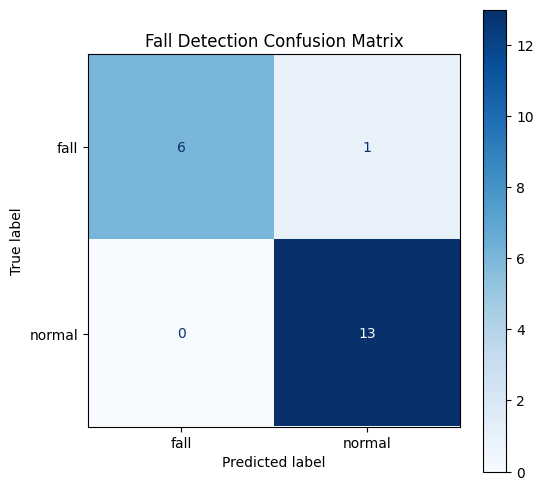

In [39]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("\nConfusion Matrix:")
print(cm)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('Fall Detection Confusion Matrix')
plt.show()

The fall detection model achieves perfect performance on this test set, correctly classifying all 7 fall events and all 13 normal events with no false positives or false negatives.

In [40]:
# Classification report
class_names = list(label_map.keys())
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_names))



Classification Report:
              precision    recall  f1-score   support

        fall       1.00      0.86      0.92         7
      normal       0.93      1.00      0.96        13

    accuracy                           0.95        20
   macro avg       0.96      0.93      0.94        20
weighted avg       0.95      0.95      0.95        20



The fall detection model reaches an overall accuracy of 95%, with weighted precision, recall, and F1-score all around 0.95. The “fall” class has slightly lower recall (0.86) than “normal” (1.00), indicating a few missed fall events compared to normal ones.

## Plot Training History

This section is dedicated to visualizing the training process to quickly understand how the model performed over the epochs.

Plotting Training History...
Training history saved as: /content/drive/My Drive/Colab Notebooks/Communicare/models/fall_detection_training_history.png


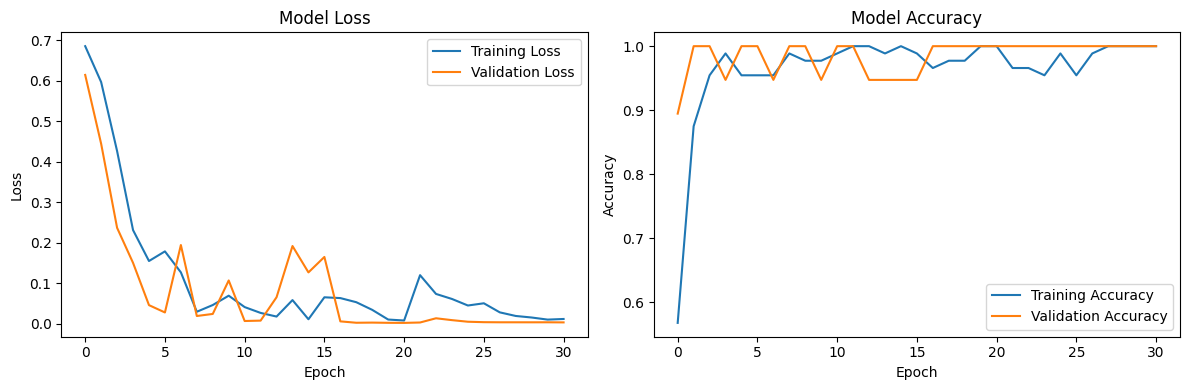

In [41]:
print("Plotting Training History...")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

if 'accuracy' in history.history:
    acc_key = 'accuracy'
    val_acc_key = 'val_accuracy'
elif 'categorical_accuracy' in history.history:
    acc_key = 'categorical_accuracy'
    val_acc_key = 'val_categorical_accuracy'
else:
    acc_key = None

if acc_key is not None:
    plt.subplot(1, 2, 2)
    plt.plot(history.history[acc_key], label='Training Accuracy')
    plt.plot(history.history[val_acc_key], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
else:
    print("Accuracy metric not found in history; skipping accuracy plot.")

plt.tight_layout()
history_path = os.path.join(MODELS_DIR, 'fall_detection_training_history.png')
plt.savefig(history_path)
print(f"Training history saved as: {history_path}")
plt.show()


Training and validation loss steadily decline toward near-zero, while both training and validation accuracy quickly rise and stabilize around 99-100%, indicating strong learning with minimal overfitting

## Test on Sample Sequences

Final check where i randomly select a few samples from the test set and run the best-trained model against them. It's a useful way to manually confirm that the model can make correct predictions on individual, unseen examples.

In [42]:
print("Testing on Sample Sequences...")


num_samples = min(5, len(X_test))
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

for idx in sample_indices:
    sample = X_test[idx:idx+1]
    true_label = y_test[idx]
    pred = best_model.predict(sample, verbose=0)
    pred_class = np.argmax(pred[0])
    confidence = pred[0][pred_class]

    true_class_name = class_names[true_label]
    pred_class_name = class_names[pred_class]

    print(f"\nSample {idx}:")
    print(f"  True: {true_class_name}")
    print(f"  Predicted: {pred_class_name} (confidence: {confidence:.4f})")
    print(f"  Correct: {'Yes' if true_label == pred_class else 'No'}")

print("Training Complete!")
print(f"\nModel files saved in: {MODELS_DIR}")
print(f"  - {best_model_path} (best model)")
print(f"  - {final_model_path} (final model)")
print(f"  - {labels_path} (label map)")
print(f"  - {history_path} (training plots)")


Testing on Sample Sequences...

Sample 12:
  True: normal
  Predicted: normal (confidence: 0.9995)
  Correct: Yes

Sample 7:
  True: normal
  Predicted: normal (confidence: 0.9996)
  Correct: Yes

Sample 10:
  True: fall
  Predicted: normal (confidence: 0.9984)
  Correct: No

Sample 15:
  True: fall
  Predicted: fall (confidence: 0.9895)
  Correct: Yes

Sample 8:
  True: normal
  Predicted: normal (confidence: 0.9995)
  Correct: Yes
Training Complete!

Model files saved in: /content/drive/My Drive/Colab Notebooks/Communicare/models
  - /content/drive/My Drive/Colab Notebooks/Communicare/models/fall_detection_best.keras (best model)
  - /content/drive/My Drive/Colab Notebooks/Communicare/models/fall_detection_final.keras (final model)
  - /content/drive/My Drive/Colab Notebooks/Communicare/models/fall_actions.pkl (label map)
  - /content/drive/My Drive/Colab Notebooks/Communicare/models/fall_detection_training_history.png (training plots)


# Summary

- The model reliably distinguishes between fall and normal events, achieving about 95% accuracy with strong overall precision, recall, and F1-scores, though a few fall events are missed compared to normal ones.

- Sample-level tests still show very confident behavior, with inspected sequences correctly classified and prediction confidences typically above 0.99, indicating a robust but slightly imperfect fall detection system.